In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import silhouette_score

In [3]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [4]:
tracks_data = pd.read_csv('/content/drive/MyDrive/240_project/Code/kmeans/preprocessed_dataset.csv')
test_tracks_data = pd.read_csv('/content/drive/MyDrive/240_project/Code/kmeans/preprocessed_test_dataset.csv')
model = pickle.load(open('/content/drive/MyDrive/240_project/Code/kmeans/kmeans_mode_nlp.sav', 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [5]:
tracks_clusters = pd.concat([pd.DataFrame(model.labels_, columns=['cluster']),tracks_data], axis=1)

In [6]:
tracks_data.head

<bound method NDFrame.head of                                   track_uri  ...                                          documents
0      spotify:track:6QHYEZlm9wyfXfEM1vSu1P  ...                  boot spanish leather time changin
1      spotify:track:3RkQ3UwOyPqpIiIvGVewuU  ...                       tambourine man bringing home
2      spotify:track:0ju1jP0cSPJ8tmojYBEI89  ...             danny song best loggins messina sittin
3      spotify:track:7ny2ATvjtKszCpLpfsGnVQ  ...         hard rain gonna fall freewheelin bob dylan
4      spotify:track:18GiV1BaXzPVYpp9rmOg0E  ...                  blowin wind freewheelin bob dylan
...                                     ...  ...                                                ...
35259  spotify:track:6cA1vWAvwPKOqDwbL75wS3  ...  heitere ges nge die meerfee schumann frauenlie...
35260  spotify:track:0Qe5L7l40nxZSSANHZgauB  ...  incoronazione poppea act pur miro monteverdi i...
35261  spotify:track:5vlhQNiopUp6forIGnFi02  ...  pergolesi stabat mat

In [7]:
test_tracks_data.head

<bound method NDFrame.head of                                  track_uri  ...                                          documents
0     spotify:track:0y8Wf6ltWpGCpgqVa21QNX  ...  afterparty feat lil yachty afterparty feat lil...
1     spotify:track:6RUKPb4LETWmmr3iAEQktW  ...                                      memories open
2     spotify:track:1sYSP7gKa5kdKIfhANfori  ...                       light low hell kitchen angel
3     spotify:track:3a1lNhkSLSkpJE4MSHpDu9  ...                              congratulation stoney
4     spotify:track:3E2Zh20GDCR9B1EYjfXWyv  ...                                         weak click
...                                    ...  ...                                                ...
3581  spotify:track:0TxXEbxn52XsuAhxb6VFZw  ...                                kiss remastered hit
3582  spotify:track:7hKpnp7A7bjiZEyywa5Qn4  ...                             girl crush pain killer
3583  spotify:track:2QVzUws1l5mzZ4v46tGHrC  ...                                

In [8]:
test_tracks_data_1=test_tracks_data.sort_values(('pl_name'))

In [9]:
len(model.labels_)

35264

## Recommender System

- If track is not in database, recommend the most popular tracks
- If track is in database, recommend tracks from clusters

#### Note: n is the recommended number of tracks 

In [10]:
def cold_start_recommend(tracks_data, n):
    most_popular = tracks_data.sort_values(by='num_followers',ascending=False).head(n)
    return most_popular[['artist_name','track_name','album_name']]


def content_based_recommend(selected_cluster, n):
    recommend_tracks = None
    selected_cluster_size = selected_cluster.shape[0]
    selected_cluster.set_index('track_uri',inplace=True)
    selected_cluster = selected_cluster[['artist_name','track_name','album_name']]
    
    if selected_cluster_size == n:
        recommend_tracks = selected_cluster
    elif selected_cluster_size > n:
        recommend_tracks = selected_cluster.sample(n)
    else:
        recommend_tracks = selected_cluster
        popular_tracks = cold_start_recommend(tracks_data,n-selected_cluster_size)
        recommend_tracks = pd.concat([recommend_tracks,popular_tracks])
    return recommend_tracks


def recommend(artist_name, track_name, tracks_clusters, n):
    recommend_tracks = None
    track = tracks_clusters.loc[np.logical_and(tracks_clusters['artist_name']==artist_name, tracks_clusters['track_name']==track_name),:]
    
    if track.shape[0] == 0:
        recommend_tracks = cold_start_recommend(tracks_clusters,n)
    else:
        cluster_label = track['cluster'].tolist()[0]
        selected_cluster = tracks_clusters.loc[tracks_clusters['cluster']==cluster_label,:]
        recommend_tracks = content_based_recommend(selected_cluster, n)
 
    return recommend_tracks['track_name'].tolist()
        

In [11]:
recommend('Bob Dylan','Boots of Spanish Leather',tracks_clusters,5)

['Hot Thing',
 'Time Is Gone',
 'Here Comes The Night Time',
 'Turn Back Time',
 '777-9311']

In [12]:
def rp_one_by_one(input_list, test_num, pred_num):
  # split test_list to two lists
  # one for predict
  # one for validation 
  test_list = []
  check_list = []
  true_count = 0
  for i in range(test_num):
    test_list.append(input_list[i])
  for i in range(pred_num):
    check_list.append(input_list[test_num + i])
  pred_list = recommend(test_list[0][0],test_list[0][1],tracks_clusters,len(check_list))
  for song in pred_list:
    if song in check_list:
      true_count += 1
  rp = true_count / pred_num
  return rp

In [13]:
test_tracks_data.head

<bound method NDFrame.head of                                  track_uri  ...                                          documents
0     spotify:track:0y8Wf6ltWpGCpgqVa21QNX  ...  afterparty feat lil yachty afterparty feat lil...
1     spotify:track:6RUKPb4LETWmmr3iAEQktW  ...                                      memories open
2     spotify:track:1sYSP7gKa5kdKIfhANfori  ...                       light low hell kitchen angel
3     spotify:track:3a1lNhkSLSkpJE4MSHpDu9  ...                              congratulation stoney
4     spotify:track:3E2Zh20GDCR9B1EYjfXWyv  ...                                         weak click
...                                    ...  ...                                                ...
3581  spotify:track:0TxXEbxn52XsuAhxb6VFZw  ...                                kiss remastered hit
3582  spotify:track:7hKpnp7A7bjiZEyywa5Qn4  ...                             girl crush pain killer
3583  spotify:track:2QVzUws1l5mzZ4v46tGHrC  ...                                

In [14]:

test_tracks_data.to_csv('/content/drive/MyDrive/240_project/Code/kmeans/trial.csv')

In [15]:
curr_input=[]
all_rp=[]
for i in range(len(test_tracks_data)) :
  if i==(len(test_tracks_data)-1):
    curr_input.append([test_tracks_data.loc[i, "artist_name"],test_tracks_data.loc[i, "track_name"]])
    pred_no=len(curr_input)-1
    all_rp.append(rp_one_by_one(curr_input,1,pred_no))
    curr_input=[]
  elif (test_tracks_data.loc[i, "pl_name"]==test_tracks_data.loc[i+1, "pl_name"]):
    curr_input.append(test_tracks_data.loc[i, "track_name"])
  else:
    curr_input.append([test_tracks_data.loc[i, "artist_name"],test_tracks_data.loc[i, "track_name"]])
    pred_no=len(curr_input)-1
    rp=rp_one_by_one(curr_input,1,pred_no)
    all_rp.append(rp)
    curr_input=[]
    if rp!=0:
      print("R-Precision score for the",len(all_rp),'th playlist:',rp)

R-Precision score for the 2 th playlist: 0.030303030303030304
R-Precision score for the 3 th playlist: 0.05670103092783505
R-Precision score for the 5 th playlist: 0.018633540372670808
R-Precision score for the 8 th playlist: 0.05
R-Precision score for the 11 th playlist: 0.004291845493562232
R-Precision score for the 20 th playlist: 0.016666666666666666
R-Precision score for the 28 th playlist: 0.06153846153846154
R-Precision score for the 33 th playlist: 0.01
R-Precision score for the 34 th playlist: 0.03529411764705882
R-Precision score for the 37 th playlist: 0.01694915254237288
R-Precision score for the 38 th playlist: 0.010638297872340425
R-Precision score for the 44 th playlist: 0.029411764705882353
R-Precision score for the 46 th playlist: 0.023255813953488372
R-Precision score for the 48 th playlist: 0.03225806451612903
R-Precision score for the 49 th playlist: 0.011764705882352941


In [16]:
print("Average R-Precision is:",np.average(all_rp))

Average R-Precision is: 0.00815412984843703


In [17]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in tracks_data.columns:
  if tracks_data[column_name].dtype == object:
    tracks_data[column_name] = le.fit_transform(tracks_data[column_name])
  else:
    pass

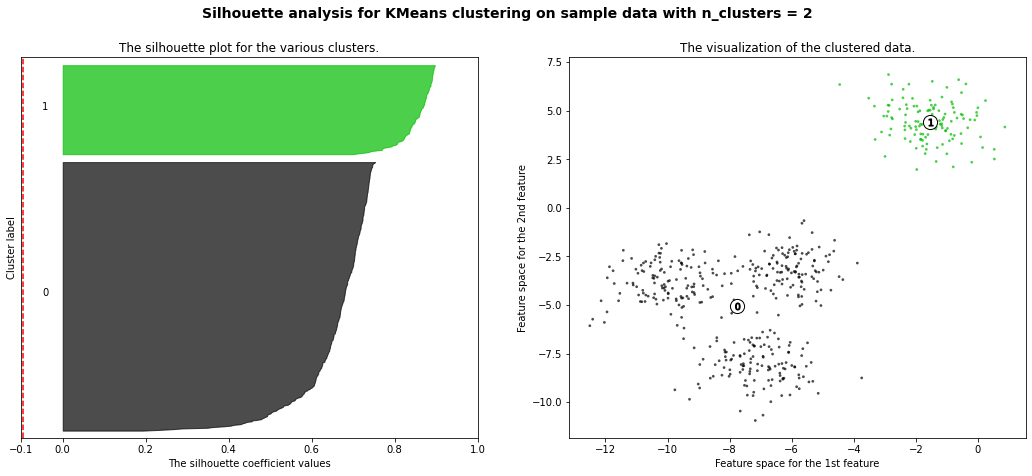

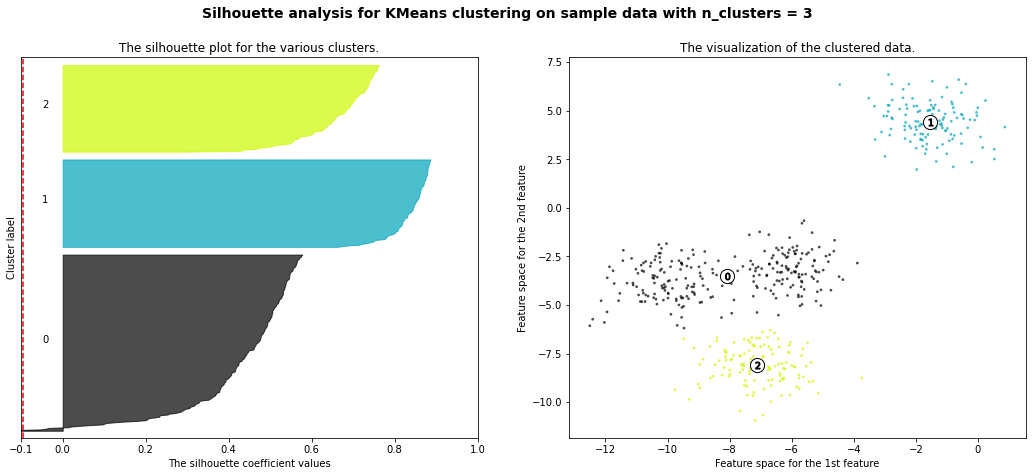

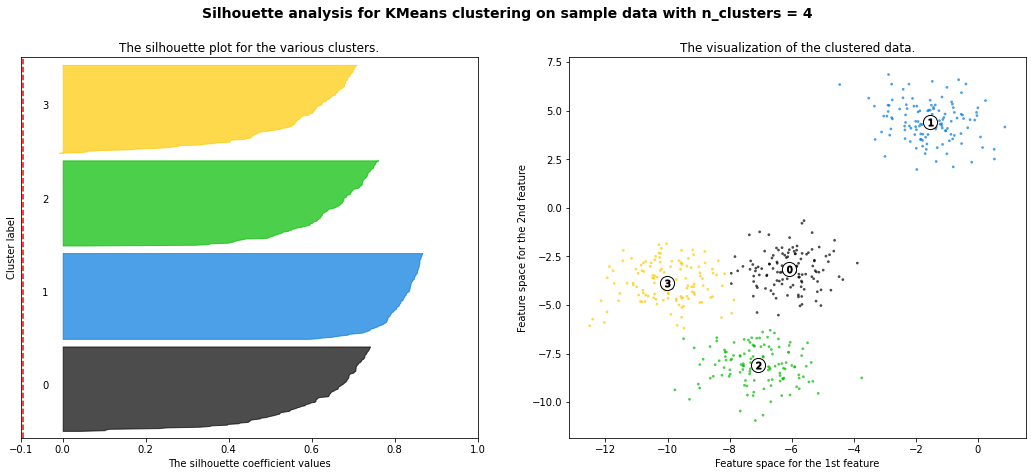

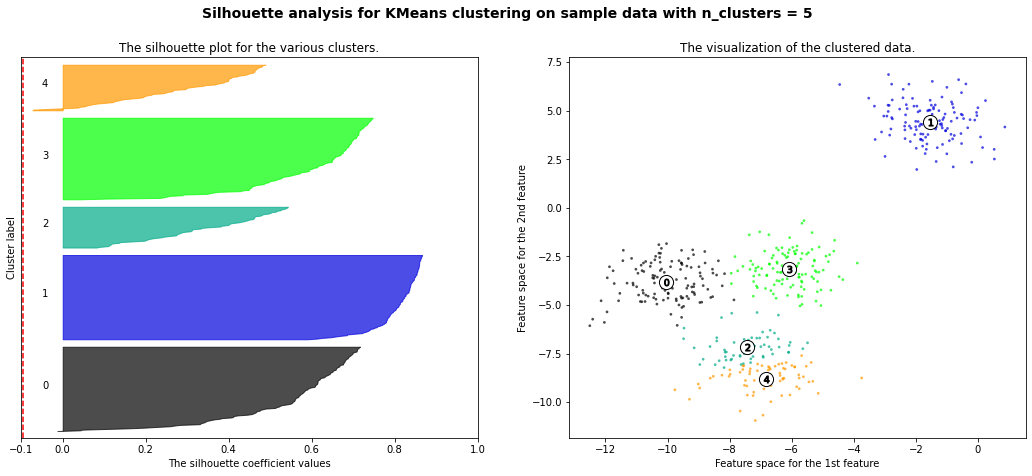

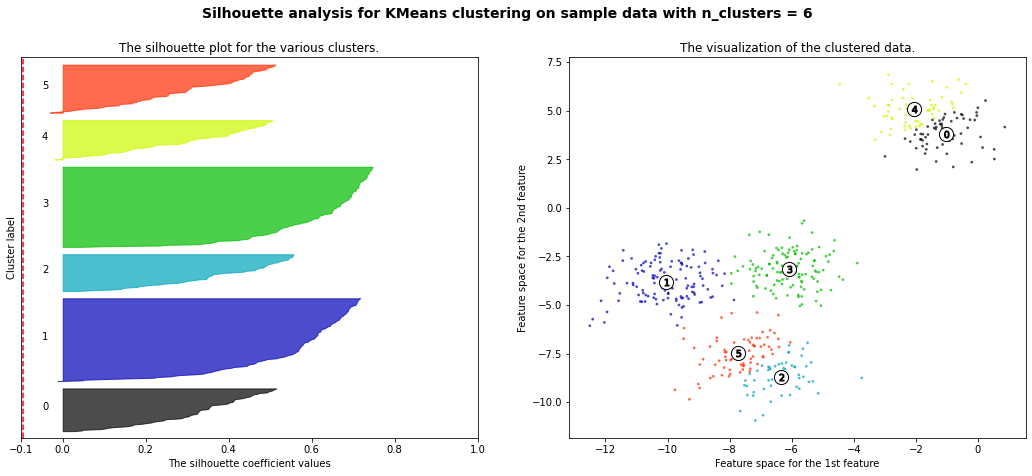

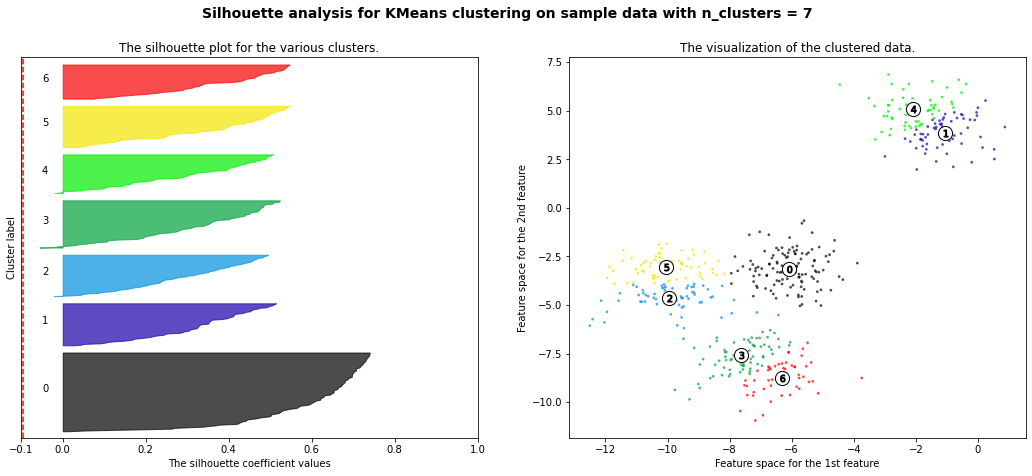

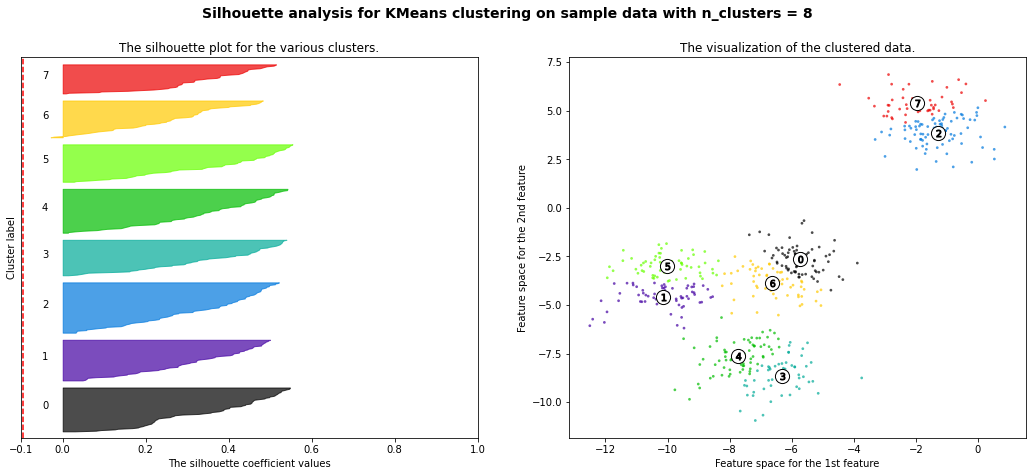

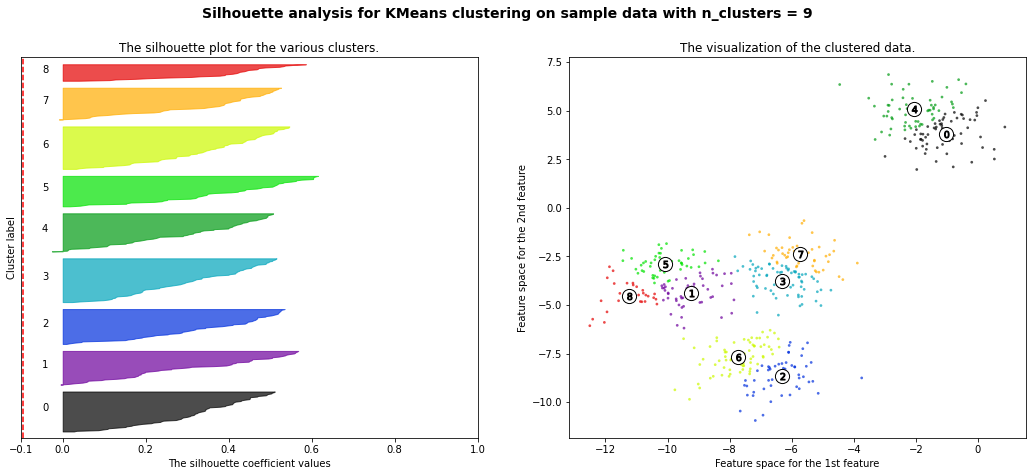

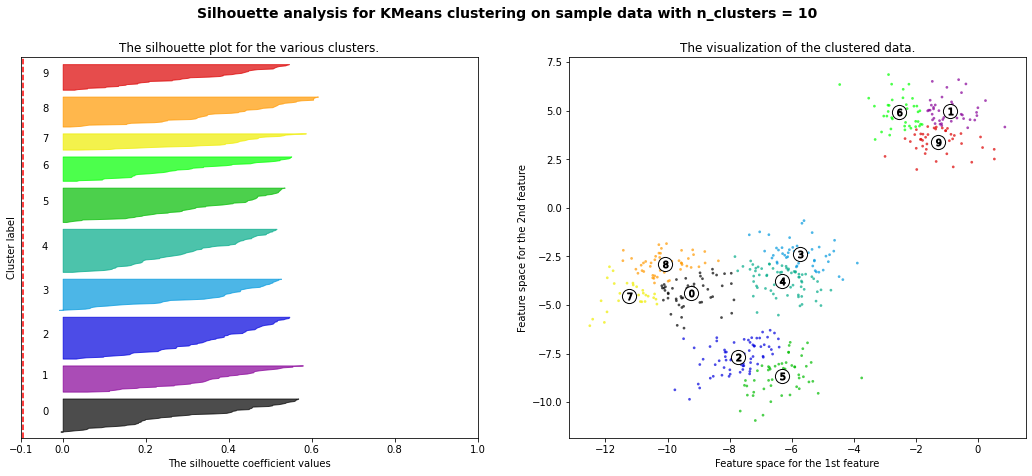

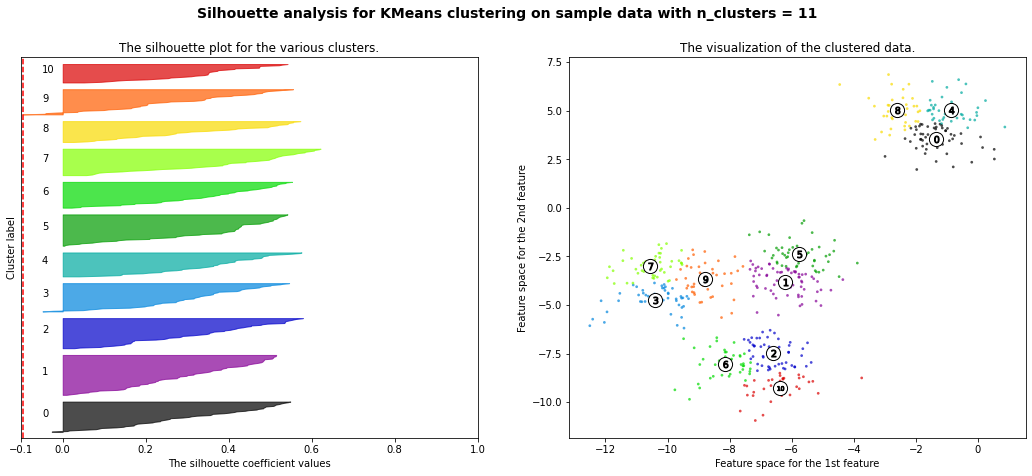

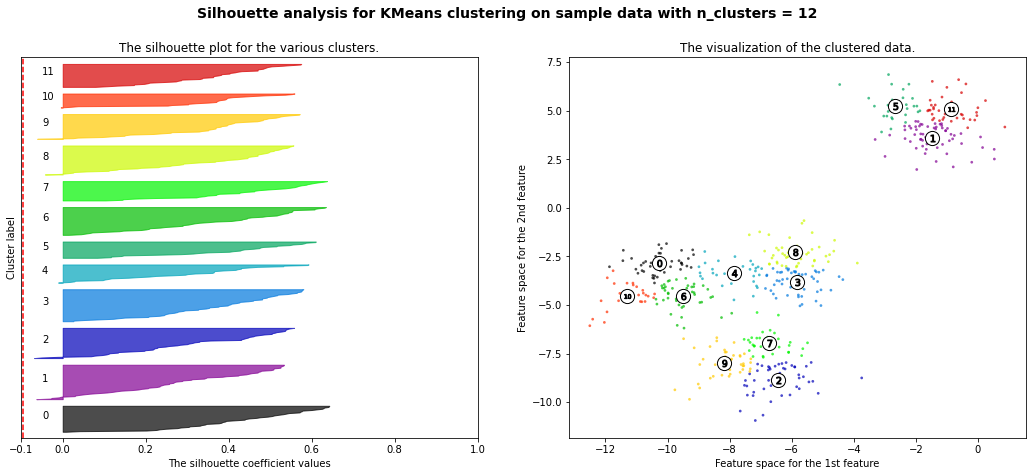

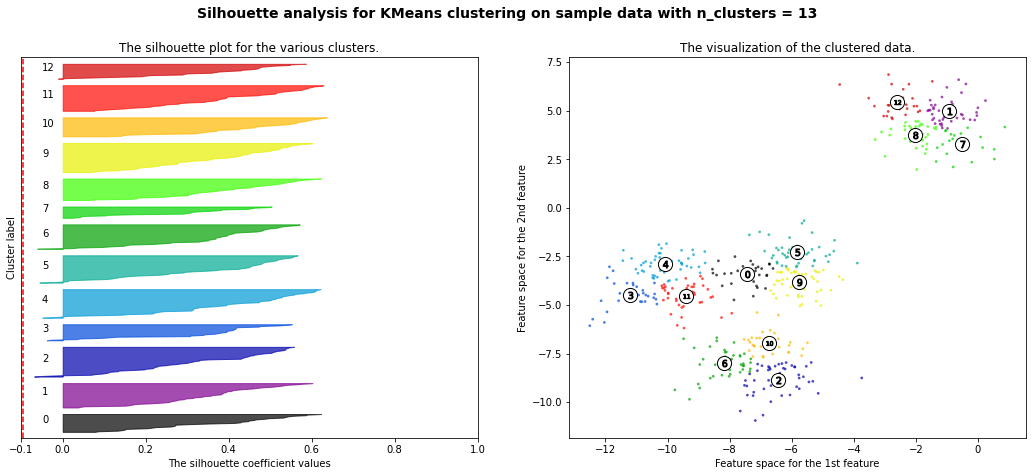

In [18]:
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10,11,12,13]

for n_clusters in range_n_clusters:
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)


    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)


    silhouette_avg = silhouette_score(tracks_data,model.labels_)


    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )


        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")


    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [19]:

print("For n_clusters =13, The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters =13, The average silhouette_score is : -0.0949738371751554


In [20]:
def drawSSEPlot(df, column_indices, n_clusters=16, max_iter=300, tol=1e-04, init='k-means++', n_init=10, algorithm='auto'):
    import matplotlib.pyplot as plt
    inertia_values = []
    for i in range(1, n_clusters+1):
        km = KMeans(n_clusters=i, max_iter=max_iter, tol=tol, init=init, n_init=n_init, random_state=1, algorithm=algorithm)
        km.fit_predict(df.iloc[:, column_indices])
        inertia_values.append(km.inertia_)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(range(1, n_clusters+1), inertia_values, color='red')
    plt.xlabel('No. of Clusters', fontsize=15)
    plt.ylabel('SSE / Inertia', fontsize=15)
    plt.title('SSE / Inertia vs No. Of Clusters', fontsize=15)
    plt.grid()
    plt.show()

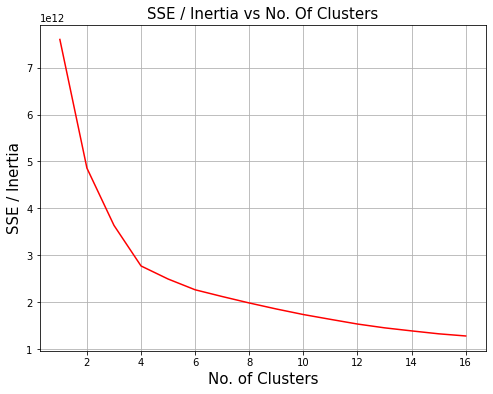

In [21]:
drawSSEPlot(tracks_data, [0, 1, 2, 3])